In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from pandas.api.types import is_numeric_dtype

# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']

df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.ffill()



In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = df['SP_price'].rolling(window=30).mean()
df['SP_MA_100'] = df['SP_price'].rolling(window=100).mean()
df['SP_MA_200'] = df['SP_price'].rolling(window=200).mean()


In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(500)


date  SP_price  dow_jones  gdp  bond_yield  home_price_index  \
0   1927-12-30     17.66        NaN  NaN         NaN               NaN   
1   1927-12-31     17.66        NaN  NaN         NaN               NaN   
2   1928-01-01     17.66        NaN  NaN         NaN               NaN   
3   1928-01-02     17.66        NaN  NaN         NaN               NaN   
4   1928-01-03     17.76        NaN  NaN         NaN               NaN   
..         ...       ...        ...  ...         ...               ...   
495 1929-05-08     26.18        NaN  NaN         NaN               NaN   
496 1929-05-09     26.02        NaN  NaN         NaN               NaN   
497 1929-05-10     26.34        NaN  NaN         NaN               NaN   
498 1929-05-11     26.34        NaN  NaN         NaN               NaN   
499 1929-05-12     26.34        NaN  NaN         NaN               NaN   

     consumer_price_index  eur  jpy  SP_price_ln   SP_MA_30  SP_MA_100  \
0                     NaN  NaN  NaN     2.871302        NaN        NaN   
1                     NaN  NaN  NaN     2.871302        NaN        NaN   
2                     NaN  NaN  NaN     2.871302        NaN        NaN   
3                     NaN  NaN  NaN     2.871302        NaN        NaN   
4                     NaN  NaN  NaN     2.876949        NaN        NaN   
..                    ...  ...  ...          ...        ...        ...   
495                   NaN  NaN  NaN     3.264996  25.596000    25.3345   
496                   NaN  NaN  NaN     3.258865  25.642333    25.3411   
497                   NaN  NaN  NaN     3.271089  25.694333    25.3500   
498                   NaN  NaN  NaN     3.271089  25.737000    25.3560   
499                   NaN  NaN  NaN     3.271089  25.776667    25.3610   

     SP_MA_200  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
495   24.39255  
496   24.41285  
497   24.43550  
498   24.45745  
499   24.47920  

[500 rows x 13 columns]

Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1283 ticks ([-17077.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting 

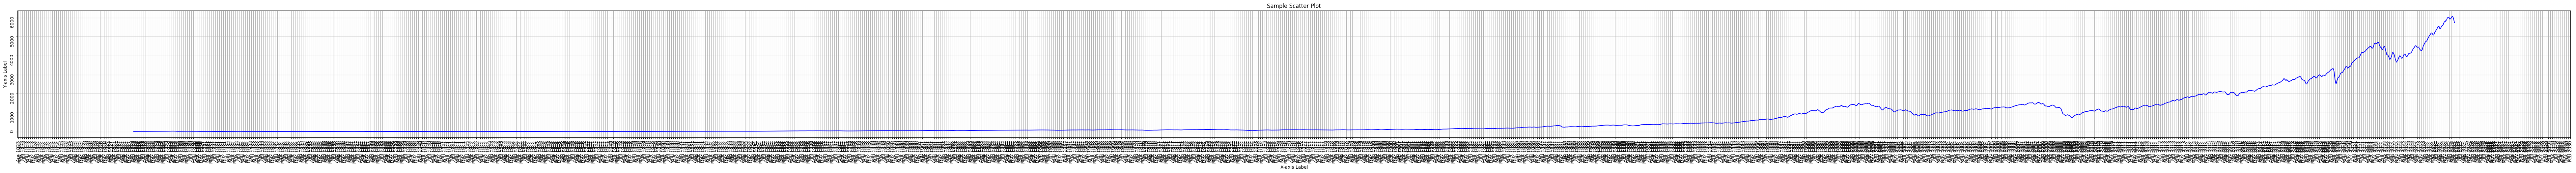

In [16]:
plt.figure(figsize=(100, 5))
plt.plot(df['date'], df['SP_MA_30'], linestyle='-', color='b', markersize=6, label="Data Line")
# Add labels and title

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

plt.xticks(rotation=90)
plt.yticks(rotation=90)

plt.title('Sample Scatter Plot')

plt.grid(True)

plt.show()

In [11]:
df_first_of_month = df[df['date'].dt.day == 1]

## Add timeseries features
- For each daily feature, get the last 10 days for that feature

In [13]:
daily_features = ["SP_price", "dow_jones", "eur", "jpy"]

for f in daily_features:
    for i in range(1,11):
        last = df[f] if i == 1 else df[f+f"-{i-1}"]
        
        df[f + f"-{i}"] = pd.concat([pd.Series([np.nan]),last], ignore_index=True)

df.iloc[35177:35187]

date  SP_price  dow_jones        gdp  bond_yield  \
35177 2024-04-21   4967.23   37986.40  29016.714        4.62   
35178 2024-04-22   5010.60   38239.98  29016.714        4.62   
35179 2024-04-23   5070.55   38503.69  29016.714        4.61   
35180 2024-04-24   5071.63   38460.92  29016.714        4.65   
35181 2024-04-25   5048.42   38085.80  29016.714        4.70   
35182 2024-04-26   5099.96   38239.66  29016.714        4.67   
35183 2024-04-27   5099.96   38239.66  29016.714        4.67   
35184 2024-04-28   5099.96   38239.66  29016.714        4.67   
35185 2024-04-29   5116.17   38386.09  29016.714        4.63   
35186 2024-04-30   5035.69   37815.92  29016.714        4.69   

       home_price_index  consumer_price_index     eur     jpy  SP_price_ln  \
35177           320.918               313.016  0.9384  154.63     8.510618   
35178           320.918               313.016  0.9384  154.84     8.519311   
35179           320.918               313.016  0.9343  154.82     8.531205   
35180           320.918               313.016  0.9345  155.34     8.531418   
35181           320.918               313.016  0.9320  155.65     8.526831   
35182           320.918               313.016  0.9349  158.33     8.536988   
35183           320.918               313.016  0.9349  158.33     8.536988   
35184           320.918               313.016  0.9349  158.33     8.536988   
35185           320.918               313.016  0.9326  156.33     8.540161   
35186           320.918               313.016  0.9374  157.80     8.524306   

       ...   jpy-1   jpy-2   jpy-3   jpy-4   jpy-5   jpy-6   jpy-7   jpy-8  \
35177  ...  154.63  154.63  154.63  154.38  154.71  154.27  153.28  153.28   
35178  ...  154.63  154.63  154.63  154.63  154.38  154.71  154.27  153.28   
35179  ...  154.84  154.63  154.63  154.63  154.63  154.38  154.71  154.27   
35180  ...  154.82  154.84  154.63  154.63  154.63  154.63  154.38  154.71   
35181  ...  155.34  154.82  154.84  154.63  154.63  154.63  154.63  154.38   
35182  ...  155.65  155.34  154.82  154.84  154.63  154.63  154.63  154.63   
35183  ...  158.33  155.65  155.34  154.82  154.84  154.63  154.63  154.63   
35184  ...  158.33  158.33  155.65  155.34  154.82  154.84  154.63  154.63   
35185  ...  158.33  158.33  158.33  155.65  155.34  154.82  154.84  154.63   
35186  ...  156.33  158.33  158.33  158.33  155.65  155.34  154.82  154.84   

        jpy-9  jpy-10  
35177  153.28  153.27  
35178  153.28  153.28  
35179  153.28  153.28  
35180  154.27  153.28  
35181  154.71  154.27  
35182  154.38  154.71  
35183  154.63  154.38  
35184  154.63  154.63  
35185  154.63  154.63  
35186  154.63  154.63  

[10 rows x 53 columns]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35516 entries, 0 to 35515
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  35516 non-null  datetime64[ns]
 1   SP_price              35516 non-null  float64       
 2   dow_jones             16528 non-null  float64       
 3   gdp                   28574 non-null  float64       
 4   bond_yield            23094 non-null  float64       
 5   home_price_index      13964 non-null  float64       
 6   consumer_price_index  28574 non-null  float64       
 7   eur                   16331 non-null  float64       
 8   jpy                   19804 non-null  float64       
 9   SP_price_ln           35516 non-null  float64       
 10  SP_MA_30              35487 non-null  float64       
 11  SP_MA_100             35417 non-null  float64       
 12  SP_MA_200             35317 non-null  float64       
 13  SP_price-1      

In [15]:
df.shape

(35516, 53)